In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

from pytorch_lightning.loggers import TensorBoardLogger, logger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# check availability of hardware acceleration
print(f'MAC MPS available: {torch.backends.mps.is_available()}')
print(f'Cuda available: {torch.cuda.is_available()}') #if cuda is avaiable, set cuda device =1

# set device to cuda
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# set seed for reproducibility
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

MAC MPS available: True
Cuda available: False


In [4]:
# load data
df = pd.read_csv('datasets/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# have a quick overview on the dataframe
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


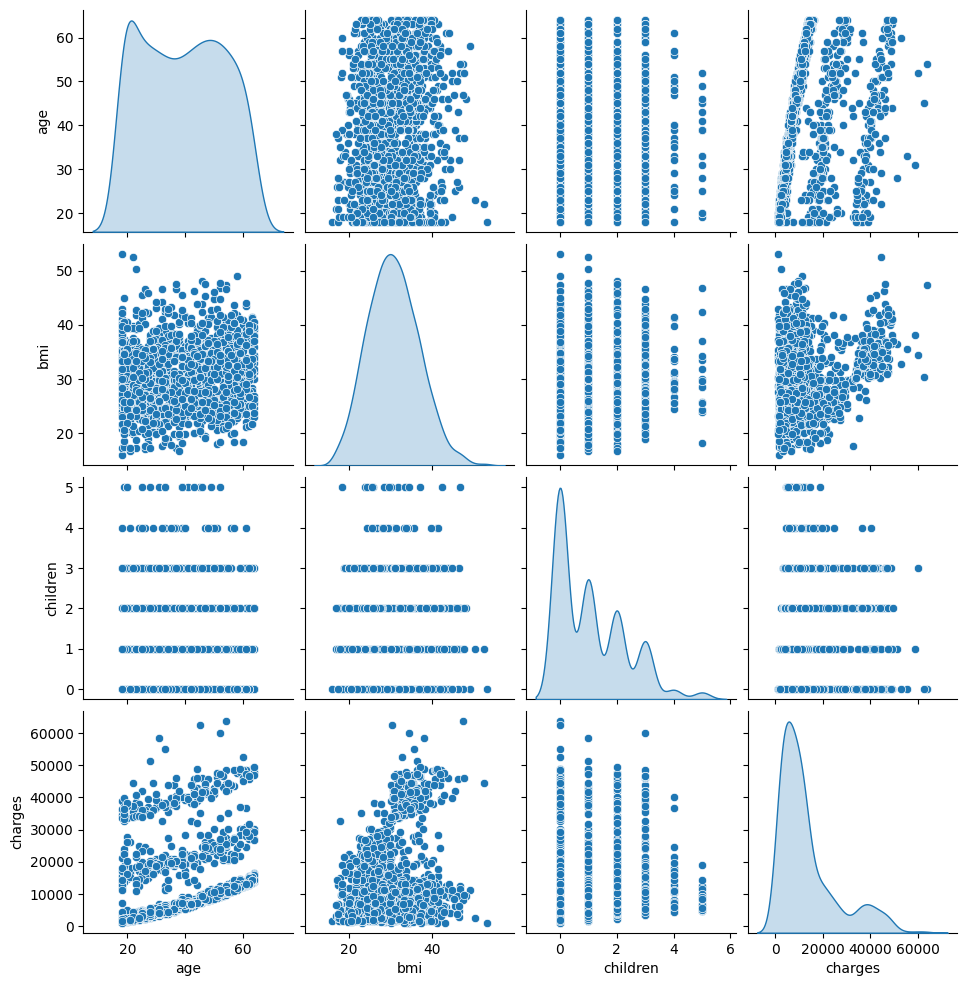

In [7]:
sns.pairplot(df, diag_kind='kde')

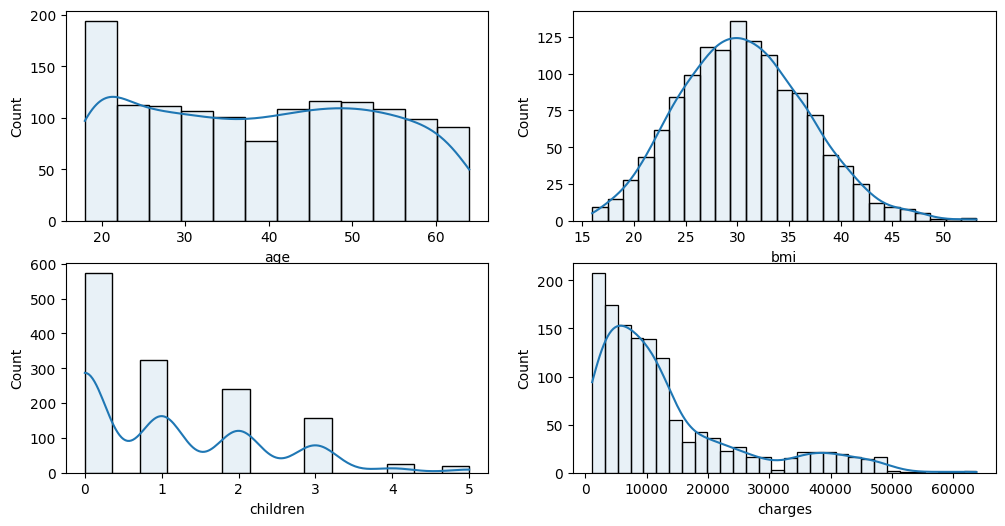

In [8]:
dist = ['age', 'bmi', 'children', 'charges']
# draw a distribution plot for variables in dist
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
for i, var in enumerate(dist):
    sns.histplot(df[var], ax=ax[i//2, i%2], kde=True, alpha=0.1)

In [10]:
# search for outliers in the dataset
for var in dist:
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(f'Outliers in {var}: {df[(df[var] < lower_bound) | (df[var] > upper_bound)].shape[0]}')

Outliers in age: 0
Outliers in bmi: 9
Outliers in children: 0
Outliers in charges: 139


In [11]:
# show the correlation between numerical variables
df[['charges', 'age', 'bmi', 'children']].corr()

,charges,age,bmi,children
charges,1.000000,0.299008,0.198341,0.067998
age,0.299008,1.000000,0.109272,0.042469
bmi,0.198341,0.109272,1.000000,0.012759
children,0.067998,0.042469,0.012759,1.000000


<AxesSubplot: xlabel='region', ylabel='charges'>

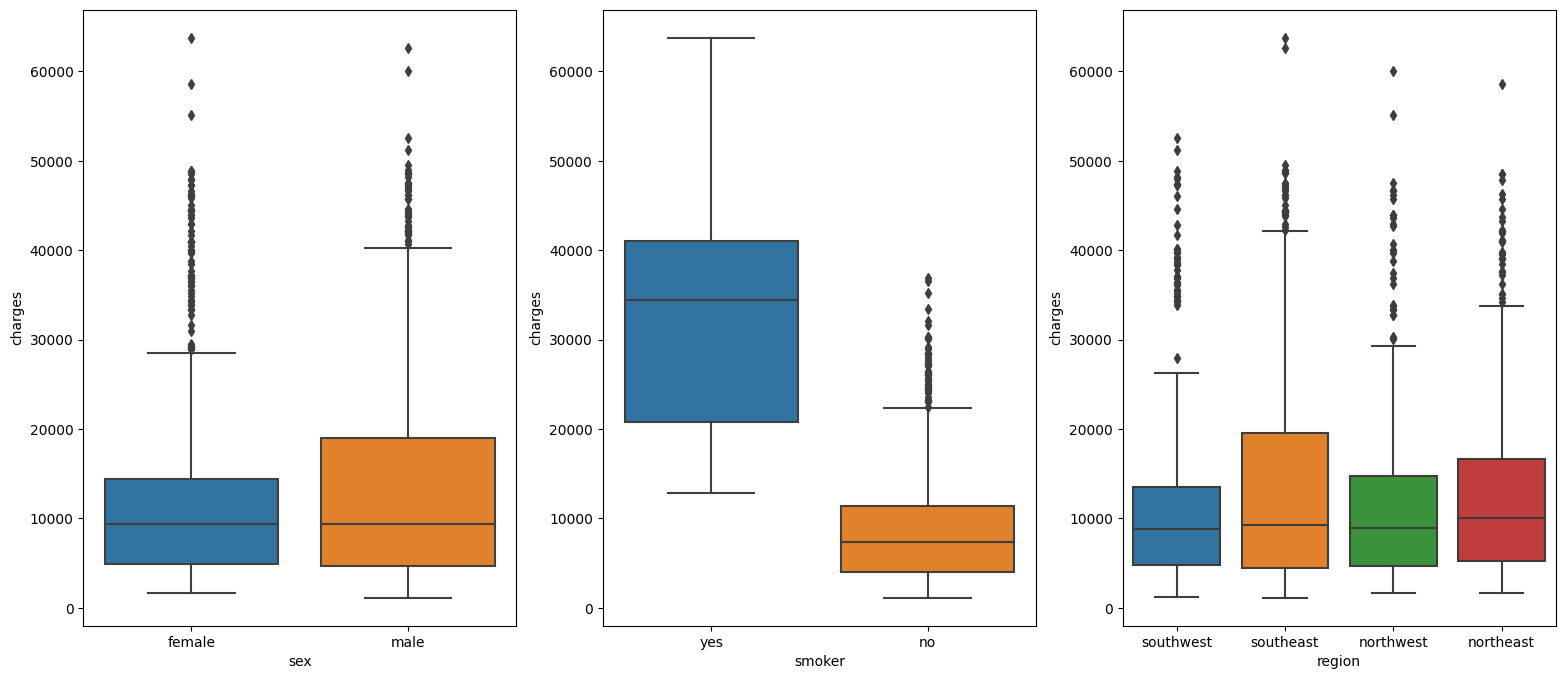

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(19, 8))
sns.boxplot(x='sex', y='charges', data=df, ax=ax[0])
sns.boxplot(x='smoker', y='charges', data=df, ax=ax[1])
sns.boxplot(x='region', y='charges', data=df, ax=ax[2])

<AxesSubplot: xlabel='age', ylabel='charges'>

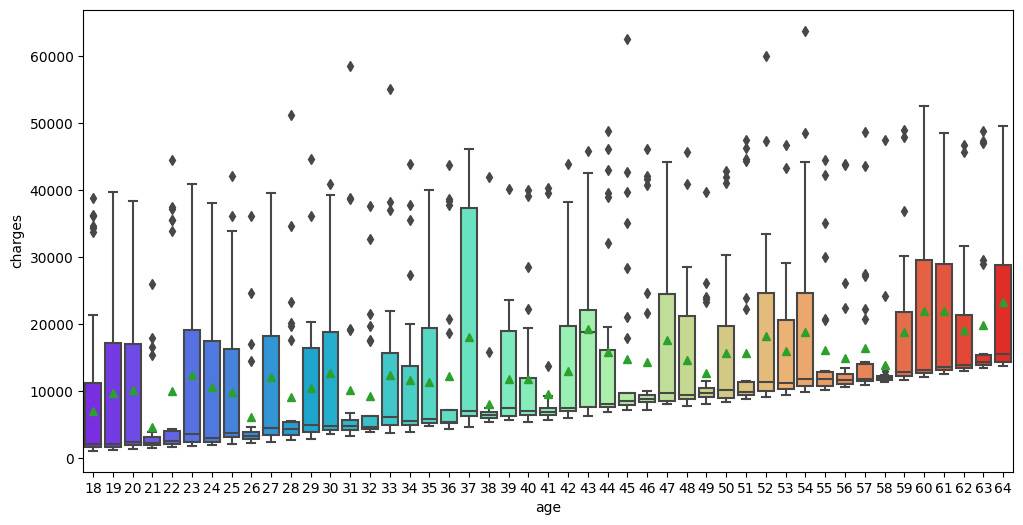

In [12]:
# draw boxplot age vs charges
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(x='age', y='charges', data=df, palette='rainbow', showmeans=True)

<AxesSubplot: >

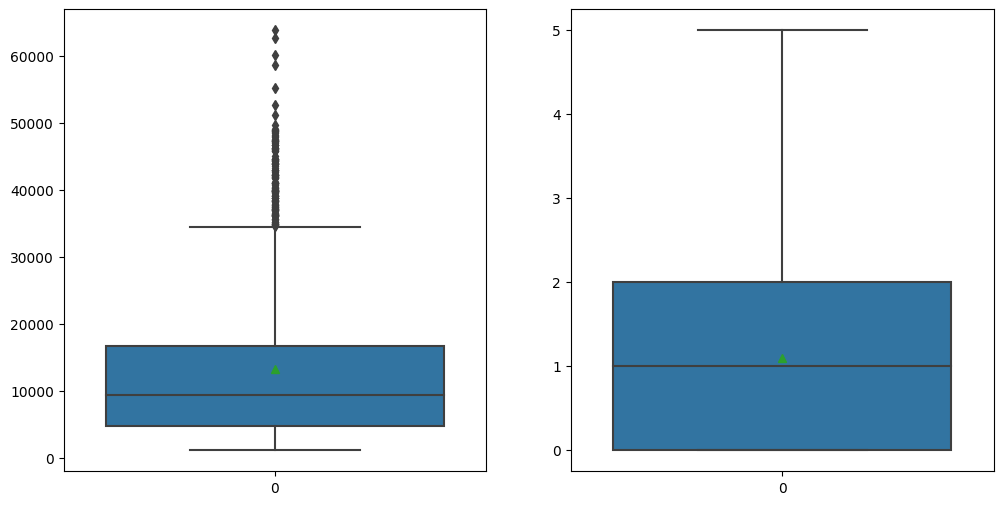

In [14]:
#draw boxplot of children and charges side by side

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#first draw boxplot of children i
sns.boxplot(df['charges'], ax=ax[0], showmeans=True)
sns.boxplot(df['children'], ax=ax[1], showmeans=True)

<AxesSubplot: ylabel='Count'>

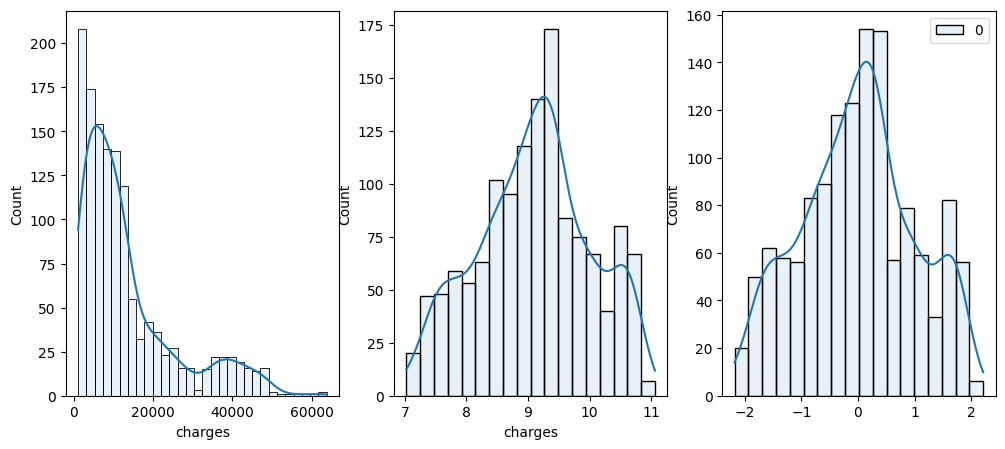

In [28]:
# log transform the charges 
## not necessary for this dataset and for y variable, but it is a good practice
charges_log = np.log(df['charges'])

from sklearn.preprocessing import PowerTransformer
power_scaler = PowerTransformer(method='yeo-johnson')
charges_power = power_scaler.fit_transform(df[['charges']])

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(df['charges'], ax=ax[0], kde=True, alpha=0.1)
sns.histplot(charges_log, ax=ax[1], kde=True, alpha=0.1)
sns.histplot(charges_power, ax=ax[2], kde=True, alpha=0.1)


In [15]:
# X, y split
X = df.drop('charges', axis=1)
y = df['charges']

# train test validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
val_size = 20/80
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=seed)

In [16]:
# concatenate X_train with y_train, then X_val with y_val
train = pd.concat([X_train, y_train], axis=1)
validation = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [220]:
print(f'Train shape: {train.shape}')
print(f'Validation shape: {validation.shape}')
print(f'Test shape: {test.shape}')


Train shape: (802, 7)


NameError: name 'validation' is not defined

In [18]:
# save the dataframes to csv
train.to_csv('datasets/train.csv', index=False)
validation.to_csv('datasets/validation.csv', index=False)
test.to_csv('datasets/test.csv', index=False)

<h1>Data Loading and data wrangling

In [2]:
# reload the dataframes and stack them
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/valid.csv')
test = pd.read_csv('data/test.csv')

df_stacked = pd.concat([train, val, test], axis=0)


In [3]:
# label encode function

def labelEncoder(df):
    # create a copy of the dataframe
    df_labelEncoded = df.copy()
    for col in df.columns:
        if df.dtypes[col] == "object":
            df_labelEncoded[col] = LabelEncoder().fit_transform(df[col])
    return df_labelEncoded

df_labelEncoded = labelEncoder(df_stacked)

In [4]:
# one hot encode function

def ohe(df):
    columns = [i for i in df.columns if df[i].dtype.name == 'object']
    df_ohe = pd.get_dummies(df, columns=columns, prefix=columns)
    return df_ohe

df_ohe = ohe(df_stacked)

In [5]:
# split the dataframes into train, val, test and fit transform the numerical variables
cols_for_scaling = ['age', 'bmi', 'children']

def split_and_transform(df,cols_for_scaling=cols_for_scaling, train=train, val=val, test=test, scaler1 = MinMaxScaler(), scaler2 = StandardScaler()):
    train=df.iloc[:len(train)]
    val=df.iloc[len(train):len(train)+len(val)]
    test=df.iloc[len(train)+len(val):]
    train.loc[:, cols_for_scaling] = scaler1.fit_transform(train.loc[:,cols_for_scaling])
    val.loc[:, cols_for_scaling] = scaler1.transform(val.loc[:,cols_for_scaling])
    test.loc[:, cols_for_scaling] = scaler1.transform(test.loc[:,cols_for_scaling])
    return train, val, test

train_le, val_le, test_le = split_and_transform(df_labelEncoded, scaler1=MinMaxScaler(), scaler2=MinMaxScaler())
train_ohe, val_ohe, test_ohe = split_and_transform(df_ohe, scaler1=MinMaxScaler(), scaler2=MinMaxScaler())

/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/3114378571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, cols_for_scaling] = scaler1.fit_transform(train.loc[:,cols_for_scaling])
/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/3114378571.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val.loc[:, cols_for_scaling] = scaler1.transform(val.loc[:,cols_for_scaling])
/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/3114378571.py:10: SettingWi

In [6]:
# optionally, log transform the y variables
train_le['charges'] = np.log(train_le['charges'])
val_le['charges'] = np.log(val_le['charges'])
test_le['charges'] = np.log(test_le['charges'])

train_ohe['charges'] = np.log(train_ohe['charges'])
val_ohe['charges'] = np.log(val_ohe['charges'])
test_ohe['charges'] = np.log(test_ohe['charges'])


/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/1578026204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_le['charges'] = np.log(train_le['charges'])
/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/1578026204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_le['charges'] = np.log(val_le['charges'])
/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/1578026204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [7]:
# create dataset class for all the dataframes
class InsuranceDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.X = df.drop('charges', axis=1)
        self.y = df['charges']
        self.X = torch.tensor(self.X.values, dtype=torch.float)
        self.y = torch.tensor(self.y.values, dtype=torch.float)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __shape__(self):
        return self.X.shape, self.y.shape  

In [8]:
train_ohe_dataset = InsuranceDataset(train_ohe)
val_ohe_dataset = InsuranceDataset(val_ohe)
test_ohe_dataset = InsuranceDataset(test_ohe)

In [9]:
train_le_dataset = InsuranceDataset(train_le)
val_le_dataset = InsuranceDataset(val_le)
test_le_dataset = InsuranceDataset(test_le)

In [10]:
# define the hidden layer for the model, so that it can be reused
def hidden_layer(in_f, out_f):
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.ReLU()
    )

# define the model
class RegressionModel(pl.LightningModule):
    def __init__(self, layers, num_neurons, batch_size, learning_rate, train_dataset, val_dataset, test_dataset):
        super().__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        input_neurons = train_dataset.X.shape[1]
        self.num_neurons = num_neurons
        hidden = [hidden_layer(num_neurons, num_neurons) for _ in range(layers)]              
        self.input = nn.Linear(input_neurons, num_neurons)
        self.hidden = nn.Sequential(*hidden)
        self.output = nn.Linear(num_neurons, 1)
        self.relu = nn.ReLU()
        self.save_hyperparameters()

    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(dim=1)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(dim=1)
        # reverse the log transform
        y_hat_reversed = torch.exp(y_hat)
        y_reversed = torch.exp(y)
        loss_reversed = F.mse_loss(y_hat_reversed, y_reversed)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_loss_reversed', loss_reversed)
        return {'val_loss': loss, 'val_loss_reversed': loss_reversed}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_reversed = torch.exp(y)
        y_hat = self(x).squeeze(dim=1)
        y_hat_reversed = torch.exp(y_hat)
        loss = F.mse_loss(y_hat, y)
        loss_reversed = F.mse_loss(y_hat_reversed, y_reversed)
        self.log('test_loss', loss)
        self.log('test_loss_reversed', loss_reversed)
        return {'test_loss': loss}

    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack([x['val_loss'] for x in validation_step_outputs]).mean()
        self.log('avg_val_loss', avg_loss)
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=0)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)

In [11]:
    ## categorical embedding using embedding space

    # determining the columns that need to be embedded
    embedded_cols = {}
    for n, col in enumerate(train.columns):
        # count the unqie values in each column, if column is of type object and has more than 2 unique values, add it to the dictioary
        if train.dtypes[col] == 'object':
            if train[col].nunique() > 2:
                embedded_cols = {col: train[col].nunique()}
                print(f'{col} has {train[col].nunique()} unique values')
    # calculate the embedding sizes
    embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
    print(f'embedding sizes: {embedding_sizes}')


region has 4 unique values
embedding sizes: [(4, 2)]


In [19]:
train_dataset[0]

(tensor([0.6957, 0.0000, 0.4844, 0.8000, 0.0000]), tensor([3]), tensor(9.3325))

In [17]:

train_le_dataset[3]

(tensor([0.3913, 0.0000, 0.3217, 0.0000, 0.0000, 0.0000]), tensor(8.6069))

In [15]:
embedded_cols.keys()

dict_keys(['region'])

In [50]:
##  testing for the regressionEmbeddedModel
# load the data
train_dataset = InsuranceEmbeddedDataset(train_le, embedded_cols=embedded_cols)
val_dataset = InsuranceEmbeddedDataset(val_le, embedded_cols=embedded_cols)
test_dataset = InsuranceEmbeddedDataset(test_le)

/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/70810927.py:5: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.X_embedded1 = self.X.loc[:,embedded_cols]
/var/folders/m_/_mwt902x1z595k65b7qf743m0000gn/T/ipykernel_10471/70810927.py:5: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.X_embedded1 = self.X.loc[:,embedded_cols]


In [51]:
# create dataset class for embedding layer model
class InsuranceEmbeddedDataset(torch.utils.data.Dataset):
    def __init__(self, df, embedded_cols=embedded_cols.keys()):
        self.X = df.drop('charges', axis=1)
        self.X_embedded1 = self.X.loc[:,embedded_cols]
        self.X_nummerical = self.X.drop(columns=embedded_cols, axis=1)
        self.y = df['charges']
        self.X_nummerical = torch.tensor(self.X_nummerical.values, dtype=torch.float)
        self.X_embedded = torch.tensor(self.X_embedded1.values, device='cpu', dtype=torch.int64)
        self.y = torch.tensor(self.y.values, dtype=torch.float)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X_nummerical[idx], self.X_embedded[idx], self.y[idx]

    def __shape__(self):
        return self.X.shape, self.y.shape  

# define the hidden layer for the model, so that it can be reused
def hidden_layer_batchnorm(in_f, out_f, dropout_num):
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.Dropout(dropout_num),
        nn.BatchNorm1d(out_f),
        nn.ReLU()
    )

# define the model
class RegressionEmbeddedModel(pl.LightningModule):
    def __init__(self, layers, num_neurons, batch_size, learning_rate, train_dataset, val_dataset, test_dataset, dropout_emb, dropout_num, embedding_sizes=embedding_sizes):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, train_dataset.X_nummerical.shape[1]

        input_nummerical = train_dataset.X_nummerical.shape[1]
        hidden = [hidden_layer_batchnorm(num_neurons, num_neurons, dropout_num) for _ in range(layers)]              
        self.input = nn.Linear(input_nummerical + self.n_emb, num_neurons)
        self.hidden = nn.Sequential(*hidden)
        self.output = nn.Linear(num_neurons, 1)

        self.bn_input = nn.BatchNorm1d(input_nummerical)
        self.drops = nn.Dropout(dropout_num)
        self.drops_emb = nn.Dropout(dropout_emb)
        self.relu = nn.ReLU()

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.num_neurons = num_neurons

        self.save_hyperparameters()

    def forward(self, X_nummerical, X_embedded):
        x = [e(X_embedded[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.drops_emb(x)
        #x2 = self.bn_input(X_nummerical)
        x2 = X_nummerical
        x = torch.cat([x, x2], 1)
        #suggestion from chatgpt
        x = x.view(x.shape[0], -1)
        x = self.input(x)
        x = self.relu(x)
        x = self.drops(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

    def training_step(self, batch, batch_idx):
        X_nummerical, X_embedded, y = batch
        x2 = X_embedded
        x = X_nummerical
        y_hat = self.forward(x, x2).squeeze(dim=1)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        X_nummerical, X_embedded, y = batch
        x = X_embedded
        x2 = X_nummerical
        y_hat = self.forward(x, x2).squeeze(dim=1)
        # reverse the log transform
        y_hat_reversed = torch.exp(y_hat)
        y_reversed = torch.exp(y)
        loss_reversed = F.mse_loss(y_hat_reversed, y_reversed)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_loss_reversed', loss_reversed)
        return {'val_loss': loss, 'val_loss_reversed': loss_reversed}

    def test_step(self, batch, batch_idx):
        X_nummerical, X_embedded, y = batch
        x = X_embedded
        x2 = X_nummerical
        y_reversed = torch.exp(y)
        y_hat = self(x, x2).squeeze(dim=1)
        y_hat_reversed = torch.exp(y_hat)
        loss = F.mse_loss(y_hat, y)
        loss_reversed = F.mse_loss(y_hat_reversed, y_reversed)
        self.log('test_loss', loss)
        self.log('test_loss_reversed', loss_reversed)
        return {'test_loss': loss}

    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack([x['val_loss'] for x in validation_step_outputs]).mean()
        self.log('avg_val_loss', avg_loss)
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=0)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)

In [52]:
# test the model with the data

logger = TensorBoardLogger('lightning_logs', name='insurance')

model = RegressionEmbeddedModel(num_neurons=32, layers=2, learning_rate=0.005, batch_size=32, 
                                train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset,
                                dropout_emb=0.1, dropout_num=0.1)
                                
trainer = pl.Trainer(accelerator=None, devices=1, max_epochs=50, logger=logger, fast_dev_run=False)
trainer.fit(model)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:101: UserWarning: attribute 'train_dataset' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:101: UserWarning: attribute 'val_dataset' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
/Users/lsacy/opt/miniconda3/

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [1]:
# testing for 64 neurons, 3 layers, learning rate of 0.001, batch size of 32

logger = TensorBoardLogger('lightning_logs', name='insurance')

model = RegressionModel(num_neurons=32, layers=2, learning_rate=0.005, batch_size=32, train_dataset=train_ohe_dataset, val_dataset=train_ohe_dataset, test_dataset=test_ohe_dataset)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=50, logger=logger, fast_dev_run=True)
trainer.fit(model)

NameError: name 'TensorBoardLogger' is not defined

In [169]:
print(trainer.logged_metrics)


{'train_loss': tensor(0.0022), 'val_loss': tensor(0.1425), 'val_loss_reversed': tensor(27132324.), 'avg_val_loss': tensor(0.1374)}


In [135]:
print(trainer.logged_metrics)


{'train_loss': tensor(0.0114), 'val_loss': tensor(0.1448), 'val_loss_reversed': tensor(28833994.), 'avg_val_loss': tensor(0.1398)}


In [138]:
model.eval()

# reverse the log transform
y_hat = np.exp(model(torch.tensor(val_le.drop('charges', axis=1).values, dtype=torch.float)).detach().numpy())
y = np.exp(val_le['charges'].values)

# calculate the mean absolute error
mae = np.mean(np.abs(y_hat - y))
print(mae)

# calculate the mean squared error
mse = np.mean((y_hat - y)**2)
print(mse)



12312.441403195595
296924393.1203129


In [172]:
trainer.test()

Restoring states from the checkpoint path at lightning_logs/insurance/version_29/checkpoints/epoch=49-step=1300.ckpt
Loaded model weights from checkpoint at lightning_logs/insurance/version_29/checkpoints/epoch=49-step=1300.ckpt


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 244.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.1872769296169281
   test_loss_reversed           28035470.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1872769296169281, 'test_loss_reversed': 28035470.0}]

In [139]:
trainer.test()

/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at lightning_logs/insurance/version_28/checkpoints/epoch=49-step=1300.ckpt
Loaded model weights from checkpoint at lightning_logs/insurance/version_28/checkpoints/epoch=49-step=1300.ckpt
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus

Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 101.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.18852858245372772
   test_loss_reversed           31503972.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.18852858245372772, 'test_loss_reversed': 31503972.0}]

In [63]:
%load_ext tensorboard

In [173]:
def optimize_model(trial):
    
    num_neurons = trial.suggest_int('num_neurons', 16, 512)
    batch_size= trial.suggest_int('batch_size', 32, 512)
    learning_rate= trial.suggest_float('learning_rate', 1e-7, 1e-1)
    layers = trial.suggest_int('layers', 1, 10)

    model = RegressionModel(layers=layers, num_neurons=num_neurons, learning_rate=learning_rate, batch_size=batch_size, train_dataset=train_ohe_dataset, val_dataset=val_ohe_dataset, test_dataset=test_ohe_dataset)
    trainer = pl.Trainer(accelerator='mps', max_epochs=50)

    trainer.fit(model)
    return trainer.callback_metrics['val_loss']
    
study = optuna.create_study(direction='minimize', study_name='insurance', storage='sqlite:///insurance.db', load_if_exists=True)
study.optimize(optimize_model, n_trials=100)

print(study.best_trial)

[I 2023-01-15 02:44:41,758] Using an existing study with name 'insurance' instead of creating a new one.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 2.7 K 
1 | hidden | Sequential | 316 K 
2 | output | Linear     | 230   
3 | relu   | ReLU       | 0     
--------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total estimated model params size (MB)


/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 56.46it/s, loss=0.821, v_num=100]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 43.58it/s, loss=0.821, v_num=100]


[I 2023-01-15 02:44:47,435] Trial 201 finished with value: 0.927402675151825 and parameters: {'num_neurons': 229, 'batch_size': 316, 'learning_rate': 0.05147348887681344, 'layers': 6}. Best is trial 201 with value: 0.927402675151825.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 2.8 K 
1 | hidden | Sequential | 321 K 
2 | output | Linear     | 232   
3 | relu   | ReLU       | 0     
--------------------------------------
324 K     Trainable params
0         Non-trainable params
324 K     Total params
1.298     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.85it/s, loss=0.871, v_num=101]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.52it/s, loss=0.871, v_num=101]


[I 2023-01-15 02:44:52,327] Trial 202 finished with value: 1.0074059963226318 and parameters: {'num_neurons': 231, 'batch_size': 316, 'learning_rate': 0.053959074802965475, 'layers': 6}. Best is trial 201 with value: 0.927402675151825.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.0 K 
1 | hidden | Sequential | 364 K 
2 | output | Linear     | 247   
3 | relu   | ReLU       | 0     
--------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.471     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 52.47it/s, loss=0.388, v_num=102]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.72it/s, loss=0.388, v_num=102]


[I 2023-01-15 02:44:57,046] Trial 203 finished with value: 0.3864937424659729 and parameters: {'num_neurons': 246, 'batch_size': 323, 'learning_rate': 0.051768692755330976, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 2.7 K 
1 | hidden | Sequential | 316 K 
2 | output | Linear     | 230   
3 | relu   | ReLU       | 0     
--------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.81it/s, loss=0.819, v_num=103]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.08it/s, loss=0.819, v_num=103]


[I 2023-01-15 02:45:01,859] Trial 204 finished with value: 0.9312162399291992 and parameters: {'num_neurons': 229, 'batch_size': 319, 'learning_rate': 0.04469053569213863, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.0 K 
1 | hidden | Sequential | 364 K 
2 | output | Linear     | 247   
3 | relu   | ReLU       | 0     
--------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.471     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.06it/s, loss=0.832, v_num=104]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.21it/s, loss=0.832, v_num=104]


[I 2023-01-15 02:45:06,528] Trial 205 finished with value: 0.9525783658027649 and parameters: {'num_neurons': 246, 'batch_size': 315, 'learning_rate': 0.05056626503755637, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.2 K 
1 | hidden | Sequential | 422 K 
2 | output | Linear     | 266   
3 | relu   | ReLU       | 0     
--------------------------------------
426 K     Trainable params
0         Non-trainable params
426 K     Total params
1.706     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 69.43it/s, loss=0.824, v_num=105]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 52.47it/s, loss=0.824, v_num=105]


[I 2023-01-15 02:45:10,845] Trial 206 finished with value: 0.9340558648109436 and parameters: {'num_neurons': 265, 'batch_size': 315, 'learning_rate': 0.045445474127113764, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.1 K 
1 | hidden | Sequential | 410 K 
2 | output | Linear     | 262   
3 | relu   | ReLU       | 0     
--------------------------------------
413 K     Trainable params
0         Non-trainable params
413 K     Total params
1.655     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 66.61it/s, loss=0.816, v_num=106]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.85it/s, loss=0.816, v_num=106]


[I 2023-01-15 02:45:15,398] Trial 207 finished with value: 0.9255176186561584 and parameters: {'num_neurons': 261, 'batch_size': 317, 'learning_rate': 0.04194486877707738, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.0 K 
1 | hidden | Sequential | 364 K 
2 | output | Linear     | 247   
3 | relu   | ReLU       | 0     
--------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.471     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 45.56it/s, loss=0.82, v_num=107]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 37.81it/s, loss=0.82, v_num=107]


[I 2023-01-15 02:45:19,681] Trial 208 finished with value: 0.9341521859169006 and parameters: {'num_neurons': 246, 'batch_size': 319, 'learning_rate': 0.047359016414764435, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.1 K 
1 | hidden | Sequential | 407 K 
2 | output | Linear     | 261   
3 | relu   | ReLU       | 0     
--------------------------------------
410 K     Trainable params
0         Non-trainable params
410 K     Total params
1.642     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 69.20it/s, loss=0.827, v_num=108]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.79it/s, loss=0.827, v_num=108]


[I 2023-01-15 02:45:24,082] Trial 209 finished with value: 0.9510838985443115 and parameters: {'num_neurons': 260, 'batch_size': 321, 'learning_rate': 0.04252468569225315, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.2 K 
1 | hidden | Sequential | 435 K 
2 | output | Linear     | 270   
3 | relu   | ReLU       | 0     
--------------------------------------
439 K     Trainable params
0         Non-trainable params
439 K     Total params
1.757     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 65.77it/s, loss=0.811, v_num=109]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.33it/s, loss=0.811, v_num=109]

[I 2023-01-15 02:45:28,752] Trial 210 finished with value: 0.9347295165061951 and parameters: {'num_neurons': 269, 'batch_size': 318, 'learning_rate': 0.039777357461327344, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.3 K 
1 | hidden | Sequential | 448 K 
2 | output | Linear     | 274   
3 | relu   | ReLU       | 0     
--------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 60.95it/s, loss=5.49e+07, v_num=110]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 68.08it/s, loss=0.852, v_num=110]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.60it/s, loss=0.852, v_num=110]


[I 2023-01-15 02:45:33,257] Trial 211 finished with value: 0.9937945604324341 and parameters: {'num_neurons': 273, 'batch_size': 317, 'learning_rate': 0.04236051754070692, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.3 K 
1 | hidden | Sequential | 452 K 
2 | output | Linear     | 275   
3 | relu   | ReLU       | 0     
--------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 68.04it/s, loss=0.694, v_num=111]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.99it/s, loss=0.694, v_num=111]


[I 2023-01-15 02:45:37,668] Trial 212 finished with value: 0.7182402610778809 and parameters: {'num_neurons': 274, 'batch_size': 314, 'learning_rate': 0.042752198267358786, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.3 K 
1 | hidden | Sequential | 458 K 
2 | output | Linear     | 277   
3 | relu   | ReLU       | 0     
--------------------------------------
462 K     Trainable params
0         Non-trainable params
462 K     Total params
1.849     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.52it/s, loss=0.804, v_num=112]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 51.09it/s, loss=0.804, v_num=112]


[I 2023-01-15 02:45:42,069] Trial 213 finished with value: 0.921604335308075 and parameters: {'num_neurons': 276, 'batch_size': 318, 'learning_rate': 0.04248002230749588, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.2 K 
1 | hidden | Sequential | 439 K 
2 | output | Linear     | 271   
3 | relu   | ReLU       | 0     
--------------------------------------
442 K     Trainable params
0         Non-trainable params
442 K     Total params
1.770     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.65it/s, loss=0.952, v_num=113]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.63it/s, loss=0.952, v_num=113]


[I 2023-01-15 02:45:46,527] Trial 214 finished with value: 1.0986546277999878 and parameters: {'num_neurons': 270, 'batch_size': 319, 'learning_rate': 0.04191198088725029, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.3 K 
1 | hidden | Sequential | 445 K 
2 | output | Linear     | 273   
3 | relu   | ReLU       | 0     
--------------------------------------
449 K     Trainable params
0         Non-trainable params
449 K     Total params
1.796     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 69.29it/s, loss=0.505, v_num=114]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 52.41it/s, loss=0.505, v_num=114]


[I 2023-01-15 02:45:50,990] Trial 215 finished with value: 0.4536667764186859 and parameters: {'num_neurons': 272, 'batch_size': 318, 'learning_rate': 0.04221472836627201, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 509 K 
2 | output | Linear     | 292   
3 | relu   | ReLU       | 0     
--------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 68.24it/s, loss=0.808, v_num=115]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.63it/s, loss=0.808, v_num=115]


[I 2023-01-15 02:45:55,568] Trial 216 finished with value: 0.9145134091377258 and parameters: {'num_neurons': 291, 'batch_size': 316, 'learning_rate': 0.04106476312473022, 'layers': 6}. Best is trial 203 with value: 0.3864937424659729.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 506 K 
2 | output | Linear     | 291   
3 | relu   | ReLU       | 0     
--------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.040     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.48it/s, loss=0.243, v_num=116]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.91it/s, loss=0.243, v_num=116]


[I 2023-01-15 02:46:00,108] Trial 217 finished with value: 0.23741209506988525 and parameters: {'num_neurons': 290, 'batch_size': 317, 'learning_rate': 0.04189302872848991, 'layers': 6}. Best is trial 217 with value: 0.23741209506988525.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 509 K 
2 | output | Linear     | 292   
3 | relu   | ReLU       | 0     
--------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 68.47it/s, loss=0.799, v_num=117]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.32it/s, loss=0.799, v_num=117]


[I 2023-01-15 02:46:04,498] Trial 218 finished with value: 0.922995388507843 and parameters: {'num_neurons': 291, 'batch_size': 317, 'learning_rate': 0.0421126261269736, 'layers': 6}. Best is trial 217 with value: 0.23741209506988525.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 523 K 
2 | output | Linear     | 296   
3 | relu   | ReLU       | 0     
--------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.22it/s, loss=0.279, v_num=118]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 51.23it/s, loss=0.279, v_num=118]


[I 2023-01-15 02:46:09,038] Trial 219 finished with value: 0.17799986898899078 and parameters: {'num_neurons': 295, 'batch_size': 317, 'learning_rate': 0.04155376405223283, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 502 K 
2 | output | Linear     | 290   
3 | relu   | ReLU       | 0     
--------------------------------------
506 K     Trainable params
0         Non-trainable params
506 K     Total params
2.026     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 66.86it/s, loss=0.813, v_num=119]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.79it/s, loss=0.813, v_num=119]


[I 2023-01-15 02:46:13,612] Trial 220 finished with value: 0.9205381274223328 and parameters: {'num_neurons': 289, 'batch_size': 318, 'learning_rate': 0.04251844644548543, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 516 K 
2 | output | Linear     | 294   
3 | relu   | ReLU       | 0     
--------------------------------------
520 K     Trainable params
0         Non-trainable params
520 K     Total params
2.083     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.94it/s, loss=0.465, v_num=120]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.60it/s, loss=0.465, v_num=120]


[I 2023-01-15 02:46:18,124] Trial 221 finished with value: 0.5151259303092957 and parameters: {'num_neurons': 293, 'batch_size': 317, 'learning_rate': 0.041504140919766036, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 523 K 
2 | output | Linear     | 296   
3 | relu   | ReLU       | 0     
--------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 65.59it/s, loss=0.644, v_num=121]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.98it/s, loss=0.644, v_num=121]


[I 2023-01-15 02:46:22,580] Trial 222 finished with value: 0.763683557510376 and parameters: {'num_neurons': 295, 'batch_size': 317, 'learning_rate': 0.04213413620161781, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 509 K 
2 | output | Linear     | 292   
3 | relu   | ReLU       | 0     
--------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 69.17it/s, loss=0.813, v_num=122]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 51.22it/s, loss=0.813, v_num=122]


[I 2023-01-15 02:46:26,958] Trial 223 finished with value: 0.9196584224700928 and parameters: {'num_neurons': 291, 'batch_size': 315, 'learning_rate': 0.04235064110807753, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 520 K 
2 | output | Linear     | 295   
3 | relu   | ReLU       | 0     
--------------------------------------
524 K     Trainable params
0         Non-trainable params
524 K     Total params
2.097     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 68.57it/s, loss=0.344, v_num=123]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.71it/s, loss=0.344, v_num=123]


[I 2023-01-15 02:46:31,455] Trial 224 finished with value: 0.33191317319869995 and parameters: {'num_neurons': 294, 'batch_size': 318, 'learning_rate': 0.041895661282194296, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.6 K 
1 | hidden | Sequential | 527 K 
2 | output | Linear     | 297   
3 | relu   | ReLU       | 0     
--------------------------------------
531 K     Trainable params
0         Non-trainable params
531 K     Total params
2.125     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 68.30it/s, loss=0.265, v_num=124]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.78it/s, loss=0.265, v_num=124]


[I 2023-01-15 02:46:35,938] Trial 225 finished with value: 0.2335207313299179 and parameters: {'num_neurons': 296, 'batch_size': 315, 'learning_rate': 0.03756023498883769, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 598 K 
2 | output | Linear     | 293   
3 | relu   | ReLU       | 0     
--------------------------------------
602 K     Trainable params
0         Non-trainable params
602 K     Total params
2.411     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 62.79it/s, loss=0.464, v_num=125]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.09it/s, loss=0.464, v_num=125]


[I 2023-01-15 02:46:40,875] Trial 226 finished with value: 0.5029416680335999 and parameters: {'num_neurons': 292, 'batch_size': 322, 'learning_rate': 0.03828334047294329, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.6 K 
1 | hidden | Sequential | 619 K 
2 | output | Linear     | 298   
3 | relu   | ReLU       | 0     
--------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.494     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.99it/s, loss=0.823, v_num=126]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.19it/s, loss=0.823, v_num=126]


[I 2023-01-15 02:46:46,040] Trial 227 finished with value: 0.924517035484314 and parameters: {'num_neurons': 297, 'batch_size': 325, 'learning_rate': 0.038480825154348614, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 598 K 
2 | output | Linear     | 293   
3 | relu   | ReLU       | 0     
--------------------------------------
602 K     Trainable params
0         Non-trainable params
602 K     Total params
2.411     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.91it/s, loss=0.84, v_num=127]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.51it/s, loss=0.84, v_num=127]


[I 2023-01-15 02:46:50,803] Trial 228 finished with value: 0.9691710472106934 and parameters: {'num_neurons': 292, 'batch_size': 328, 'learning_rate': 0.03701596376534511, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 608 K 
2 | output | Linear     | 319   
3 | relu   | ReLU       | 0     
--------------------------------------
612 K     Trainable params
0         Non-trainable params
612 K     Total params
2.451     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.68it/s, loss=0.822, v_num=128]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.75it/s, loss=0.822, v_num=128]


[I 2023-01-15 02:46:55,501] Trial 229 finished with value: 0.9370521306991577 and parameters: {'num_neurons': 318, 'batch_size': 324, 'learning_rate': 0.04490412080789168, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 692 K 
2 | output | Linear     | 315   
3 | relu   | ReLU       | 0     
--------------------------------------
696 K     Trainable params
0         Non-trainable params
696 K     Total params
2.786     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.60it/s, loss=0.701, v_num=129]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 47.06it/s, loss=0.701, v_num=129]


[I 2023-01-15 02:47:00,535] Trial 230 finished with value: 0.8355918526649475 and parameters: {'num_neurons': 314, 'batch_size': 305, 'learning_rate': 0.03896588413352874, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 602 K 
2 | output | Linear     | 294   
3 | relu   | ReLU       | 0     
--------------------------------------
606 K     Trainable params
0         Non-trainable params
606 K     Total params
2.427     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.31it/s, loss=0.349, v_num=130]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.83it/s, loss=0.349, v_num=130]


[I 2023-01-15 02:47:05,406] Trial 231 finished with value: 0.3003505766391754 and parameters: {'num_neurons': 293, 'batch_size': 307, 'learning_rate': 0.038642826279189885, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 598 K 
2 | output | Linear     | 293   
3 | relu   | ReLU       | 0     
--------------------------------------
602 K     Trainable params
0         Non-trainable params
602 K     Total params
2.411     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 47.86it/s, loss=0.825, v_num=131]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 38.73it/s, loss=0.825, v_num=131]


[I 2023-01-15 02:47:10,090] Trial 232 finished with value: 0.9315481185913086 and parameters: {'num_neurons': 292, 'batch_size': 307, 'learning_rate': 0.038064180068805416, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 607 K 
2 | output | Linear     | 295   
3 | relu   | ReLU       | 0     
--------------------------------------
610 K     Trainable params
0         Non-trainable params
610 K     Total params
2.444     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.10it/s, loss=0.764, v_num=132]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.62it/s, loss=0.764, v_num=132]


[I 2023-01-15 02:47:15,059] Trial 233 finished with value: 0.846512496471405 and parameters: {'num_neurons': 294, 'batch_size': 305, 'learning_rate': 0.03750842532804347, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 611 K 
2 | output | Linear     | 296   
3 | relu   | ReLU       | 0     
--------------------------------------
615 K     Trainable params
0         Non-trainable params
615 K     Total params
2.460     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.74it/s, loss=0.856, v_num=133]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.31it/s, loss=0.856, v_num=133]


[I 2023-01-15 02:47:19,819] Trial 234 finished with value: 1.013415813446045 and parameters: {'num_neurons': 295, 'batch_size': 305, 'learning_rate': 0.03692664177633914, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 666 K 
2 | output | Linear     | 309   
3 | relu   | ReLU       | 0     
--------------------------------------
670 K     Trainable params
0         Non-trainable params
670 K     Total params
2.681     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.73it/s, loss=0.307, v_num=134]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.28it/s, loss=0.307, v_num=134]


[I 2023-01-15 02:47:24,887] Trial 235 finished with value: 0.25852179527282715 and parameters: {'num_neurons': 308, 'batch_size': 309, 'learning_rate': 0.03311331032132451, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 661 K 
2 | output | Linear     | 308   
3 | relu   | ReLU       | 0     
--------------------------------------
665 K     Trainable params
0         Non-trainable params
665 K     Total params
2.664     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 44.80it/s, loss=0.827, v_num=135]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 35.05it/s, loss=0.827, v_num=135]


[I 2023-01-15 02:47:30,029] Trial 236 finished with value: 0.9355927109718323 and parameters: {'num_neurons': 307, 'batch_size': 306, 'learning_rate': 0.032245164426319806, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.5 K 
1 | hidden | Sequential | 582 K 
2 | output | Linear     | 289   
3 | relu   | ReLU       | 0     
--------------------------------------
586 K     Trainable params
0         Non-trainable params
586 K     Total params
2.345     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.40it/s, loss=0.655, v_num=136]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.47it/s, loss=0.655, v_num=136]


[I 2023-01-15 02:47:35,388] Trial 237 finished with value: 0.24958176910877228 and parameters: {'num_neurons': 288, 'batch_size': 303, 'learning_rate': 0.03855856962970667, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 832 K 
2 | output | Linear     | 323   
3 | relu   | ReLU       | 0     
--------------------------------------
836 K     Trainable params
0         Non-trainable params
836 K     Total params
3.345     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 52.38it/s, loss=2.49e+08, v_num=137]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 58.88it/s, loss=0.973, v_num=137]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 41.53it/s, loss=0.973, v_num=137]


[I 2023-01-15 02:47:41,255] Trial 238 finished with value: 1.0665793418884277 and parameters: {'num_neurons': 322, 'batch_size': 301, 'learning_rate': 0.034264015246437254, 'layers': 8}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.4 K 
1 | hidden | Sequential | 578 K 
2 | output | Linear     | 288   
3 | relu   | ReLU       | 0     
--------------------------------------
582 K     Trainable params
0         Non-trainable params
582 K     Total params
2.329     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.89it/s, loss=0.511, v_num=138]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 35.60it/s, loss=0.511, v_num=138]


[I 2023-01-15 02:47:46,484] Trial 239 finished with value: 0.5420708060264587 and parameters: {'num_neurons': 287, 'batch_size': 308, 'learning_rate': 0.040464070835882875, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.4 K 
1 | hidden | Sequential | 562 K 
2 | output | Linear     | 284   
3 | relu   | ReLU       | 0     
--------------------------------------
566 K     Trainable params
0         Non-trainable params
566 K     Total params
2.265     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 60.98it/s, loss=0.84, v_num=139]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 45.11it/s, loss=0.84, v_num=139]


[I 2023-01-15 02:47:51,605] Trial 240 finished with value: 0.9685438871383667 and parameters: {'num_neurons': 283, 'batch_size': 309, 'learning_rate': 0.04037271668791893, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.6 K 
1 | hidden | Sequential | 644 K 
2 | output | Linear     | 304   
3 | relu   | ReLU       | 0     
--------------------------------------
648 K     Trainable params
0         Non-trainable params
648 K     Total params
2.595     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 53.29it/s, loss=3.18e+08, v_num=140]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 62.23it/s, loss=0.835, v_num=140]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 45.35it/s, loss=0.835, v_num=140]


[I 2023-01-15 02:47:56,961] Trial 241 finished with value: 0.9508273005485535 and parameters: {'num_neurons': 303, 'batch_size': 328, 'learning_rate': 0.038806461332678906, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 647 K 
2 | output | Linear     | 329   
3 | relu   | ReLU       | 0     
--------------------------------------
651 K     Trainable params
0         Non-trainable params
651 K     Total params
2.607     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.96it/s, loss=0.399, v_num=141]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.34it/s, loss=0.399, v_num=141]


[I 2023-01-15 02:48:02,183] Trial 242 finished with value: 0.39412838220596313 and parameters: {'num_neurons': 328, 'batch_size': 298, 'learning_rate': 0.04383693593123384, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 651 K 
2 | output | Linear     | 330   
3 | relu   | ReLU       | 0     
--------------------------------------
655 K     Trainable params
0         Non-trainable params
655 K     Total params
2.623     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.44it/s, loss=0.816, v_num=142]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.23it/s, loss=0.816, v_num=142]


[I 2023-01-15 02:48:07,552] Trial 243 finished with value: 0.9271547198295593 and parameters: {'num_neurons': 329, 'batch_size': 298, 'learning_rate': 0.04177589732994283, 'layers': 6}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 759 K 
2 | output | Linear     | 330   
3 | relu   | ReLU       | 0     
--------------------------------------
764 K     Trainable params
0         Non-trainable params
764 K     Total params
3.057     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 63.42it/s, loss=0.818, v_num=143]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 43.29it/s, loss=0.818, v_num=143]


[I 2023-01-15 02:48:13,232] Trial 244 finished with value: 0.9296032786369324 and parameters: {'num_neurons': 329, 'batch_size': 299, 'learning_rate': 0.04183882104490938, 'layers': 7}. Best is trial 219 with value: 0.17799986898899078.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.2 K 
1 | hidden | Sequential | 728 K 
2 | output | Linear     | 349   
3 | relu   | ReLU       | 0     
--------------------------------------
733 K     Trainable params
0         Non-trainable params
733 K     Total params
2.933     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 66.21it/s, loss=0.202, v_num=144]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 46.19it/s, loss=0.202, v_num=144]


[I 2023-01-15 02:48:18,519] Trial 245 finished with value: 0.1724710613489151 and parameters: {'num_neurons': 348, 'batch_size': 299, 'learning_rate': 0.03478268256158262, 'layers': 6}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.4 K 
1 | hidden | Sequential | 574 K 
2 | output | Linear     | 287   
3 | relu   | ReLU       | 0     
--------------------------------------
578 K     Trainable params
0         Non-trainable params
578 K     Total params
2.313     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 57.71it/s, loss=0.621, v_num=145]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 43.48it/s, loss=0.621, v_num=145]


[I 2023-01-15 02:48:23,742] Trial 246 finished with value: 0.46664121747016907 and parameters: {'num_neurons': 286, 'batch_size': 309, 'learning_rate': 0.035243800287981075, 'layers': 7}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.2 K 
1 | hidden | Sequential | 874 K 
2 | output | Linear     | 354   
3 | relu   | ReLU       | 0     
--------------------------------------
879 K     Trainable params
0         Non-trainable params
879 K     Total params
3.517     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 58.55it/s, loss=0.926, v_num=146]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 40.44it/s, loss=0.926, v_num=146]


[I 2023-01-15 02:48:29,078] Trial 247 finished with value: 1.0545413494110107 and parameters: {'num_neurons': 353, 'batch_size': 307, 'learning_rate': 0.03435834245516505, 'layers': 7}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.4 K 
1 | hidden | Sequential | 574 K 
2 | output | Linear     | 287   
3 | relu   | ReLU       | 0     
--------------------------------------
578 K     Trainable params
0         Non-trainable params
578 K     Total params
2.313     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 64.41it/s, loss=0.809, v_num=147]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.26it/s, loss=0.809, v_num=147]


[I 2023-01-15 02:48:34,017] Trial 248 finished with value: 0.9206780791282654 and parameters: {'num_neurons': 286, 'batch_size': 328, 'learning_rate': 0.0312625275133423, 'layers': 7}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.4 K 
1 | hidden | Sequential | 489 K 
2 | output | Linear     | 286   
3 | relu   | ReLU       | 0     
--------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.971     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 67.40it/s, loss=0.512, v_num=148]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 50.13it/s, loss=0.512, v_num=148]

[I 2023-01-15 02:48:38,982] Trial 249 finished with value: 0.602726936340332 and parameters: {'num_neurons': 285, 'batch_size': 300, 'learning_rate': 0.03542022482701819, 'layers': 6}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.4 K 
1 | hidden | Sequential | 647 K 
2 | output | Linear     | 285   
3 | relu   | ReLU       | 0     
--------------------------------------
651 K     Trainable params
0         Non-trainable params
651 K     Total params
2.605     Total estimated model params size (MB)



Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 62.07it/s, loss=0.436, v_num=149]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 44.25it/s, loss=0.436, v_num=149]


[I 2023-01-15 02:48:44,247] Trial 250 finished with value: 0.39714768528938293 and parameters: {'num_neurons': 284, 'batch_size': 296, 'learning_rate': 0.031061364260669317, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 771 K 
2 | output | Linear     | 311   
3 | relu   | ReLU       | 0     
--------------------------------------
775 K     Trainable params
0         Non-trainable params
775 K     Total params
3.101     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 61.59it/s, loss=0.255, v_num=150]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.95it/s, loss=0.255, v_num=150]


[I 2023-01-15 02:48:49,822] Trial 251 finished with value: 0.23820562660694122 and parameters: {'num_neurons': 310, 'batch_size': 295, 'learning_rate': 0.029793610531754652, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.6 K 
1 | hidden | Sequential | 727 K 
2 | output | Linear     | 302   
3 | relu   | ReLU       | 0     
--------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2.925     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 62.38it/s, loss=0.824, v_num=151]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 44.61it/s, loss=0.824, v_num=151]


[I 2023-01-15 02:48:55,105] Trial 252 finished with value: 0.9472557902336121 and parameters: {'num_neurons': 301, 'batch_size': 294, 'learning_rate': 0.035121257693757506, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 761 K 
2 | output | Linear     | 309   
3 | relu   | ReLU       | 0     
--------------------------------------
765 K     Trainable params
0         Non-trainable params
765 K     Total params
3.062     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 57.16it/s, loss=0.274, v_num=152]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.02it/s, loss=0.274, v_num=152]


[I 2023-01-15 02:49:00,159] Trial 253 finished with value: 0.2022261768579483 and parameters: {'num_neurons': 308, 'batch_size': 301, 'learning_rate': 0.02488715313380313, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 761 K 
2 | output | Linear     | 309   
3 | relu   | ReLU       | 0     
--------------------------------------
765 K     Trainable params
0         Non-trainable params
765 K     Total params
3.062     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 58.00it/s, loss=0.356, v_num=153]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.19it/s, loss=0.356, v_num=153]


[I 2023-01-15 02:49:05,224] Trial 254 finished with value: 0.32513028383255005 and parameters: {'num_neurons': 308, 'batch_size': 298, 'learning_rate': 0.025852734275594366, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 771 K 
2 | output | Linear     | 311   
3 | relu   | ReLU       | 0     
--------------------------------------
775 K     Trainable params
0         Non-trainable params
775 K     Total params
3.101     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 59.63it/s, loss=0.182, v_num=154]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.45it/s, loss=0.182, v_num=154]


[I 2023-01-15 02:49:10,592] Trial 255 finished with value: 0.18753069639205933 and parameters: {'num_neurons': 310, 'batch_size': 288, 'learning_rate': 0.02485398721112238, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 771 K 
2 | output | Linear     | 311   
3 | relu   | ReLU       | 0     
--------------------------------------
775 K     Trainable params
0         Non-trainable params
775 K     Total params
3.101     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 58.93it/s, loss=0.394, v_num=155]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.52it/s, loss=0.394, v_num=155]


[I 2023-01-15 02:49:15,749] Trial 256 finished with value: 0.3598998486995697 and parameters: {'num_neurons': 310, 'batch_size': 290, 'learning_rate': 0.02440177503340122, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 776 K 
2 | output | Linear     | 312   
3 | relu   | ReLU       | 0     
--------------------------------------
780 K     Trainable params
0         Non-trainable params
780 K     Total params
3.121     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 59.08it/s, loss=0.197, v_num=156]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.94it/s, loss=0.197, v_num=156]


[I 2023-01-15 02:49:21,041] Trial 257 finished with value: 0.18027836084365845 and parameters: {'num_neurons': 311, 'batch_size': 287, 'learning_rate': 0.022298604946163304, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 766 K 
2 | output | Linear     | 310   
3 | relu   | ReLU       | 0     
--------------------------------------
770 K     Trainable params
0         Non-trainable params
770 K     Total params
3.081     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 58.13it/s, loss=0.389, v_num=157]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.389, v_num=157]


[I 2023-01-15 02:49:26,507] Trial 258 finished with value: 0.19270549714565277 and parameters: {'num_neurons': 309, 'batch_size': 286, 'learning_rate': 0.02731077672131546, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.1 K 
1 | hidden | Sequential | 943 K 
2 | output | Linear     | 344   
3 | relu   | ReLU       | 0     
--------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.794     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 59.84it/s, loss=0.787, v_num=158]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 42.15it/s, loss=0.787, v_num=158]


[I 2023-01-15 02:49:32,072] Trial 259 finished with value: 0.892549991607666 and parameters: {'num_neurons': 343, 'batch_size': 292, 'learning_rate': 0.02415404808399398, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 746 K 
2 | output | Linear     | 306   
3 | relu   | ReLU       | 0     
--------------------------------------
750 K     Trainable params
0         Non-trainable params
750 K     Total params
3.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 58.65it/s, loss=0.634, v_num=159]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 41.68it/s, loss=0.634, v_num=159]


[I 2023-01-15 02:49:37,848] Trial 260 finished with value: 0.7332213521003723 and parameters: {'num_neurons': 305, 'batch_size': 287, 'learning_rate': 0.02722578374307494, 'layers': 8}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 884 K 
2 | output | Linear     | 314   
3 | relu   | ReLU       | 0     
--------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.554     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 56.14it/s, loss=0.529, v_num=160]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.529, v_num=160]


[I 2023-01-15 02:49:44,144] Trial 261 finished with value: 0.49923187494277954 and parameters: {'num_neurons': 313, 'batch_size': 281, 'learning_rate': 0.022708207075324026, 'layers': 9}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 873 K 
2 | output | Linear     | 312   
3 | relu   | ReLU       | 0     
--------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.509     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 49.95it/s, loss=0.299, v_num=161]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 32.91it/s, loss=0.299, v_num=161]


[I 2023-01-15 02:49:50,345] Trial 262 finished with value: 0.2523479163646698 and parameters: {'num_neurons': 311, 'batch_size': 281, 'learning_rate': 0.022953622023974017, 'layers': 9}. Best is trial 245 with value: 0.1724710613489151.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 878 K 
2 | output | Linear     | 313   
3 | relu   | ReLU       | 0     
--------------------------------------
882 K     Trainable params
0         Non-trainable params
882 K     Total params
3.532     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 55.82it/s, loss=0.177, v_num=162]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.177, v_num=162]


[I 2023-01-15 02:49:57,321] Trial 263 finished with value: 0.16772373020648956 and parameters: {'num_neurons': 312, 'batch_size': 280, 'learning_rate': 0.02131181857686972, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 873 K 
2 | output | Linear     | 312   
3 | relu   | ReLU       | 0     
--------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.509     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.58it/s, loss=0.252, v_num=163]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 34.21it/s, loss=0.252, v_num=163]


[I 2023-01-15 02:50:03,575] Trial 264 finished with value: 0.1698146015405655 and parameters: {'num_neurons': 311, 'batch_size': 277, 'learning_rate': 0.02082933390075925, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 884 K 
2 | output | Linear     | 314   
3 | relu   | ReLU       | 0     
--------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.554     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 56.01it/s, loss=0.284, v_num=164]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.284, v_num=164]


[I 2023-01-15 02:50:09,733] Trial 265 finished with value: 0.17572619020938873 and parameters: {'num_neurons': 313, 'batch_size': 276, 'learning_rate': 0.021141648449293834, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 786 K 
2 | output | Linear     | 314   
3 | relu   | ReLU       | 0     
--------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.161     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 56.96it/s, loss=0.45, v_num=165]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 32.10it/s, loss=0.45, v_num=165]


[I 2023-01-15 02:50:16,449] Trial 266 finished with value: 0.4770626127719879 and parameters: {'num_neurons': 313, 'batch_size': 278, 'learning_rate': 0.02000731020265801, 'layers': 8}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 947 K 
2 | output | Linear     | 325   
3 | relu   | ReLU       | 0     
--------------------------------------
951 K     Trainable params
0         Non-trainable params
951 K     Total params
3.808     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 47.49it/s, loss=0.144, v_num=166]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 34.41it/s, loss=0.144, v_num=166]


[I 2023-01-15 02:50:24,686] Trial 267 finished with value: 0.1713670790195465 and parameters: {'num_neurons': 324, 'batch_size': 272, 'learning_rate': 0.022319070352165567, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 953 K 
2 | output | Linear     | 326   
3 | relu   | ReLU       | 0     
--------------------------------------
957 K     Trainable params
0         Non-trainable params
957 K     Total params
3.831     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.816, v_num=167]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 27.69it/s, loss=0.816, v_num=167]


[I 2023-01-15 02:50:33,243] Trial 268 finished with value: 0.9254646897315979 and parameters: {'num_neurons': 325, 'batch_size': 272, 'learning_rate': 0.019081777488378495, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.1 K 
1 | hidden | Sequential | 1.0 M 
2 | output | Linear     | 341   
3 | relu   | ReLU       | 0     
--------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.192     Total estimated model params size (MB)


/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  6.60it/s, loss=1.21e+08, v_num=168]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 55.15it/s, loss=0.133, v_num=168]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 40.64it/s, loss=0.133, v_num=168]


[I 2023-01-15 02:50:43,951] Trial 269 finished with value: 0.1879248470067978 and parameters: {'num_neurons': 340, 'batch_size': 263, 'learning_rate': 0.025249553933579822, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.2 K 
1 | hidden | Sequential | 1.1 M 
2 | output | Linear     | 350   
3 | relu   | ReLU       | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.416     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 52.59it/s, loss=1.02, v_num=169]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 38.74it/s, loss=1.02, v_num=169]


[I 2023-01-15 02:50:53,934] Trial 270 finished with value: 0.696425199508667 and parameters: {'num_neurons': 349, 'batch_size': 258, 'learning_rate': 0.024927669183000697, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.0 K 
1 | hidden | Sequential | 1.1 M 
2 | output | Linear     | 333   
3 | relu   | ReLU       | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.440     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 60.28it/s, loss=0.645, v_num=170]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 45.30it/s, loss=0.645, v_num=170]


[I 2023-01-15 02:51:04,545] Trial 271 finished with value: 0.9581591486930847 and parameters: {'num_neurons': 332, 'batch_size': 267, 'learning_rate': 0.017761972713082077, 'layers': 10}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 851 K 
2 | output | Linear     | 308   
3 | relu   | ReLU       | 0     
--------------------------------------
854 K     Trainable params
0         Non-trainable params
854 K     Total params
3.420     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 45.30it/s, loss=0.768, v_num=171]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 32.70it/s, loss=0.768, v_num=171]


[I 2023-01-15 02:51:11,403] Trial 272 finished with value: 0.8680078983306885 and parameters: {'num_neurons': 307, 'batch_size': 285, 'learning_rate': 0.028410946368145264, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.5 K 
1 | hidden | Sequential | 1.2 M 
2 | output | Linear     | 372   
3 | relu   | ReLU       | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.988     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 54.67it/s, loss=0.813, v_num=172]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 36.68it/s, loss=0.813, v_num=172]


[I 2023-01-15 02:51:18,667] Trial 273 finished with value: 0.9113019108772278 and parameters: {'num_neurons': 371, 'batch_size': 278, 'learning_rate': 0.02287857823597134, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.0 K 
1 | hidden | Sequential | 911 K 
2 | output | Linear     | 338   
3 | relu   | ReLU       | 0     
--------------------------------------
915 K     Trainable params
0         Non-trainable params
915 K     Total params
3.663     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 29.15it/s, loss=3.89e+07, v_num=173]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 57.31it/s, loss=0.627, v_num=173]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.627, v_num=173]


[I 2023-01-15 02:51:25,515] Trial 274 finished with value: 0.7529149055480957 and parameters: {'num_neurons': 337, 'batch_size': 288, 'learning_rate': 0.025848735436453073, 'layers': 8}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 816 K 
2 | output | Linear     | 320   
3 | relu   | ReLU       | 0     
--------------------------------------
820 K     Trainable params
0         Non-trainable params
820 K     Total params
3.283     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  8.36it/s, loss=1.66e+08, v_num=174]

NaN or Inf found in input tensor.


Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 39.38it/s, loss=5.52e+07, v_num=174]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 57.75it/s, loss=0.719, v_num=174]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.59it/s, loss=0.719, v_num=174]


[I 2023-01-15 02:51:33,715] Trial 275 finished with value: 0.8706282377243042 and parameters: {'num_neurons': 319, 'batch_size': 264, 'learning_rate': 0.029661919268978064, 'layers': 8}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 867 K 
2 | output | Linear     | 311   
3 | relu   | ReLU       | 0     
--------------------------------------
871 K     Trainable params
0         Non-trainable params
871 K     Total params
3.487     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 54.98it/s, loss=0.181, v_num=175]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 38.39it/s, loss=0.181, v_num=175]


[I 2023-01-15 02:51:40,363] Trial 276 finished with value: 0.17907863855361938 and parameters: {'num_neurons': 310, 'batch_size': 273, 'learning_rate': 0.02231693669953837, 'layers': 9}. Best is trial 263 with value: 0.16772373020648956.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 878 K 
2 | output | Linear     | 313   
3 | relu   | ReLU       | 0     
--------------------------------------
882 K     Trainable params
0         Non-trainable params
882 K     Total params
3.532     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 52.70it/s, loss=0.15, v_num=176]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.15, v_num=176]


[I 2023-01-15 02:51:46,715] Trial 277 finished with value: 0.151951402425766 and parameters: {'num_neurons': 312, 'batch_size': 270, 'learning_rate': 0.02180432969814558, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 873 K 
2 | output | Linear     | 312   
3 | relu   | ReLU       | 0     
--------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.509     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 63.02it/s, loss=0.808, v_num=177]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 45.89it/s, loss=0.808, v_num=177]


[I 2023-01-15 02:51:54,659] Trial 278 finished with value: 0.9217634797096252 and parameters: {'num_neurons': 311, 'batch_size': 251, 'learning_rate': 0.022841842517377624, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.9 K 
1 | hidden | Sequential | 930 K 
2 | output | Linear     | 322   
3 | relu   | ReLU       | 0     
--------------------------------------
934 K     Trainable params
0         Non-trainable params
934 K     Total params
3.738     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 48.08it/s, loss=0.378, v_num=178]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 31.82it/s, loss=0.378, v_num=178]


[I 2023-01-15 02:52:01,563] Trial 279 finished with value: 0.4147373139858246 and parameters: {'num_neurons': 321, 'batch_size': 270, 'learning_rate': 0.026748091532919502, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 851 K 
2 | output | Linear     | 308   
3 | relu   | ReLU       | 0     
--------------------------------------
854 K     Trainable params
0         Non-trainable params
854 K     Total params
3.420     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 52.75it/s, loss=0.28, v_num=179]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 37.50it/s, loss=0.28, v_num=179]


[I 2023-01-15 02:52:08,058] Trial 280 finished with value: 0.24126985669136047 and parameters: {'num_neurons': 307, 'batch_size': 275, 'learning_rate': 0.020844555966889434, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.7 K 
1 | hidden | Sequential | 839 K 
2 | output | Linear     | 306   
3 | relu   | ReLU       | 0     
--------------------------------------
843 K     Trainable params
0         Non-trainable params
843 K     Total params
3.376     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, loss=4.15e+03, v_num=180]

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 54.08it/s, loss=0.817, v_num=180]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.817, v_num=180]


[I 2023-01-15 02:52:14,559] Trial 281 finished with value: 0.9285943508148193 and parameters: {'num_neurons': 305, 'batch_size': 272, 'learning_rate': 0.016378850353751192, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.4 K 
1 | hidden | Sequential | 1.2 M 
2 | output | Linear     | 365   
3 | relu   | ReLU       | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.802     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 59.49it/s, loss=0.242, v_num=181]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.56it/s, loss=0.242, v_num=181]


[I 2023-01-15 02:52:23,289] Trial 282 finished with value: 0.17576880753040314 and parameters: {'num_neurons': 364, 'batch_size': 258, 'learning_rate': 0.021084330073563085, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 3.8 K 
1 | hidden | Sequential | 895 K 
2 | output | Linear     | 316   
3 | relu   | ReLU       | 0     
--------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.600     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 56.04it/s, loss=0.127, v_num=182]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 43.57it/s, loss=0.127, v_num=182]


[I 2023-01-15 02:52:31,987] Trial 283 finished with value: 0.15667405724525452 and parameters: {'num_neurons': 315, 'batch_size': 257, 'learning_rate': 0.021165164410286, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.3 K 
1 | hidden | Sequential | 1.1 M 
2 | output | Linear     | 356   
3 | relu   | ReLU       | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.568     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 63.37it/s, loss=0.163, v_num=183]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 46.98it/s, loss=0.163, v_num=183]


[I 2023-01-15 02:52:40,033] Trial 284 finished with value: 0.19670972228050232 and parameters: {'num_neurons': 355, 'batch_size': 257, 'learning_rate': 0.021892272206587994, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.2 K 
1 | hidden | Sequential | 1.1 M 
2 | output | Linear     | 352   
3 | relu   | ReLU       | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.466     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 63.71it/s, loss=0.777, v_num=184]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 47.95it/s, loss=0.777, v_num=184]


[I 2023-01-15 02:52:48,535] Trial 285 finished with value: 0.923172652721405 and parameters: {'num_neurons': 351, 'batch_size': 255, 'learning_rate': 0.021088106574059858, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.3 K 
1 | hidden | Sequential | 1.2 M 
2 | output | Linear     | 361   
3 | relu   | ReLU       | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.697     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 56.63it/s, loss=0.602, v_num=185]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 39.21it/s, loss=0.602, v_num=185]


[I 2023-01-15 02:52:56,724] Trial 286 finished with value: 0.29207906126976013 and parameters: {'num_neurons': 360, 'batch_size': 262, 'learning_rate': 0.021366689751047364, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.3 K 
1 | hidden | Sequential | 1.2 M 
2 | output | Linear     | 363   
3 | relu   | ReLU       | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.749     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 46.95it/s, loss=0.172, v_num=186]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 36.23it/s, loss=0.172, v_num=186]


[I 2023-01-15 02:53:06,082] Trial 287 finished with value: 0.2444986253976822 and parameters: {'num_neurons': 362, 'batch_size': 248, 'learning_rate': 0.021385592490005777, 'layers': 9}. Best is trial 277 with value: 0.151951402425766.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.4 K 
1 | hidden | Sequential | 1.2 M 
2 | output | Linear     | 365   
3 | relu   | ReLU       | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.802     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 62.48it/s, loss=0.134, v_num=187]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 46.48it/s, loss=0.134, v_num=187]


[I 2023-01-15 02:53:14,849] Trial 288 finished with value: 0.13798460364341736 and parameters: {'num_neurons': 364, 'batch_size': 233, 'learning_rate': 0.021386763230346547, 'layers': 9}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.1 K 
1 | hidden | Sequential | 1.2 M 
2 | output | Linear     | 342   
3 | relu   | ReLU       | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.683     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 42.17it/s, loss=2.8e+06, v_num=188] 

NaN or Inf found in input tensor.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 60.83it/s, loss=0.181, v_num=188]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.67it/s, loss=0.181, v_num=188]


[I 2023-01-15 02:53:23,484] Trial 289 finished with value: 0.14959484338760376 and parameters: {'num_neurons': 341, 'batch_size': 240, 'learning_rate': 0.018960182704906525, 'layers': 10}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.6 K 
1 | hidden | Sequential | 1.5 M 
2 | output | Linear     | 383   
3 | relu   | ReLU       | 0     
--------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.872     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 60.87it/s, loss=0.134, v_num=189]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 43.54it/s, loss=0.134, v_num=189]


[I 2023-01-15 02:53:32,050] Trial 290 finished with value: 0.1473383754491806 and parameters: {'num_neurons': 382, 'batch_size': 249, 'learning_rate': 0.018612445305154275, 'layers': 10}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.3 K 
1 | hidden | Sequential | 1.3 M 
2 | output | Linear     | 356   
3 | relu   | ReLU       | 0     
--------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.074     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 60.90it/s, loss=0.812, v_num=190]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.92it/s, loss=0.812, v_num=190]


[I 2023-01-15 02:53:40,473] Trial 291 finished with value: 0.9294250011444092 and parameters: {'num_neurons': 355, 'batch_size': 230, 'learning_rate': 0.013470151743741245, 'layers': 10}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.8 K 
1 | hidden | Sequential | 1.4 M 
2 | output | Linear     | 397   
3 | relu   | ReLU       | 0     
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.680     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 59.68it/s, loss=0.147, v_num=191]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 43.77it/s, loss=0.147, v_num=191]


[I 2023-01-15 02:53:49,962] Trial 292 finished with value: 0.17857873439788818 and parameters: {'num_neurons': 396, 'batch_size': 235, 'learning_rate': 0.018979224706848777, 'layers': 9}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.9 K 
1 | hidden | Sequential | 1.5 M 
2 | output | Linear     | 409   
3 | relu   | ReLU       | 0     
--------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.029     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 58.08it/s, loss=0.405, v_num=192]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 40.61it/s, loss=0.405, v_num=192]


[I 2023-01-15 02:53:59,701] Trial 293 finished with value: 0.42818284034729004 and parameters: {'num_neurons': 408, 'batch_size': 236, 'learning_rate': 0.01873537800639069, 'layers': 9}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.8 K 
1 | hidden | Sequential | 1.6 M 
2 | output | Linear     | 401   
3 | relu   | ReLU       | 0     
--------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.437     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 56.04it/s, loss=0.824, v_num=193]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 40.99it/s, loss=0.824, v_num=193]


[I 2023-01-15 02:54:08,334] Trial 294 finished with value: 0.8792545795440674 and parameters: {'num_neurons': 400, 'batch_size': 244, 'learning_rate': 0.020902985886371593, 'layers': 10}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.4 K 
1 | hidden | Sequential | 1.4 M 
2 | output | Linear     | 370   
3 | relu   | ReLU       | 0     
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.480     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 57.98it/s, loss=0.839, v_num=194]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 40.27it/s, loss=0.839, v_num=194]


[I 2023-01-15 02:54:17,289] Trial 295 finished with value: 0.9652058482170105 and parameters: {'num_neurons': 369, 'batch_size': 207, 'learning_rate': 0.016966427918684433, 'layers': 10}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.5 K 
1 | hidden | Sequential | 1.3 M 
2 | output | Linear     | 378   
3 | relu   | ReLU       | 0     
--------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.150     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 57.02it/s, loss=0.744, v_num=195]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 39.13it/s, loss=0.744, v_num=195]


[I 2023-01-15 02:54:25,457] Trial 296 finished with value: 0.8552391529083252 and parameters: {'num_neurons': 377, 'batch_size': 228, 'learning_rate': 0.020682795538897566, 'layers': 9}. Best is trial 288 with value: 0.13798460364341736.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.6 K 
1 | hidden | Sequential | 1.3 M 
2 | output | Linear     | 384   
3 | relu   | ReLU       | 0     
--------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.315     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 58.21it/s, loss=0.133, v_num=196]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.25it/s, loss=0.133, v_num=196]


[I 2023-01-15 02:54:33,489] Trial 297 finished with value: 0.1339951753616333 and parameters: {'num_neurons': 383, 'batch_size': 248, 'learning_rate': 0.018906682638040993, 'layers': 9}. Best is trial 297 with value: 0.1339951753616333.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.7 K 
1 | hidden | Sequential | 1.4 M 
2 | output | Linear     | 390   
3 | relu   | ReLU       | 0     
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.482     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 62.44it/s, loss=0.368, v_num=197]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 45.29it/s, loss=0.368, v_num=197]


[I 2023-01-15 02:54:41,987] Trial 298 finished with value: 0.23785966634750366 and parameters: {'num_neurons': 389, 'batch_size': 237, 'learning_rate': 0.015537002097064032, 'layers': 9}. Best is trial 297 with value: 0.1339951753616333.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.7 K 
1 | hidden | Sequential | 1.4 M 
2 | output | Linear     | 392   
3 | relu   | ReLU       | 0     
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.538     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 61.36it/s, loss=0.129, v_num=198]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.27it/s, loss=0.129, v_num=198]


[I 2023-01-15 02:54:50,562] Trial 299 finished with value: 0.13342277705669403 and parameters: {'num_neurons': 391, 'batch_size': 239, 'learning_rate': 0.012029900886458151, 'layers': 9}. Best is trial 299 with value: 0.13342277705669403.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.8 K 
1 | hidden | Sequential | 1.4 M 
2 | output | Linear     | 397   
3 | relu   | ReLU       | 0     
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.680     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 64.25it/s, loss=0.179, v_num=199]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 46.32it/s, loss=0.179, v_num=199]


[I 2023-01-15 02:54:58,239] Trial 300 finished with value: 0.16059985756874084 and parameters: {'num_neurons': 396, 'batch_size': 214, 'learning_rate': 0.012562603297384711, 'layers': 9}. Best is trial 299 with value: 0.13342277705669403.


FrozenTrial(number=299, values=[0.13342277705669403], datetime_start=datetime.datetime(2023, 1, 15, 2, 54, 41, 990766), datetime_complete=datetime.datetime(2023, 1, 15, 2, 54, 50, 556763), params={'batch_size': 239, 'layers': 9, 'learning_rate': 0.012029900886458151, 'num_neurons': 391}, distributions={'batch_size': IntDistribution(high=512, log=False, low=32, step=1), 'layers': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=1e-07, step=None), 'num_neurons': IntDistribution(high=512, log=False, low=16, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=300, state=TrialState.COMPLETE, value=None)


In [174]:
print(study.best_params)

{'batch_size': 239, 'layers': 9, 'learning_rate': 0.012029900886458151, 'num_neurons': 391}


In [178]:
# start a new trainer with the best hyperparameters
model = RegressionModel(**study.best_params,  train_dataset=train_ohe_dataset, val_dataset=val_ohe_dataset, test_dataset=test_ohe_dataset)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=50, logger=logger, fast_dev_run=False)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory lightning_logs/insurance/version_29/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type       | Params
--------------------------------------
0 | input  | Linear     | 4.7 K 
1 | hidden | Sequential | 1.4 M 
2 | output | Linear     | 392   
3 | relu   | ReLU       | 0     
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.538     Total estimated model params size (MB)


/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lsacy/opt/miniconda3/envs/clcnlu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (4)

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 64.11it/s, loss=0.171, v_num=29]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 41.96it/s, loss=0.171, v_num=29]


In [179]:
print(trainer.logged_metrics)

{'train_loss': tensor(0.1540), 'val_loss': tensor(0.1404), 'val_loss_reversed': tensor(31848670.), 'avg_val_loss': tensor(0.1624)}


In [180]:
trainer.test()

Restoring states from the checkpoint path at lightning_logs/insurance/version_29/checkpoints/epoch=49-step=200-v1.ckpt
Loaded model weights from checkpoint at lightning_logs/insurance/version_29/checkpoints/epoch=49-step=200-v1.ckpt


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 53.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.19460749626159668
   test_loss_reversed           39134988.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.19460749626159668, 'test_loss_reversed': 39134988.0}]

In [181]:
study.best_params, study.best_value

({'batch_size': 239,
  'layers': 9,
  'learning_rate': 0.012029900886458151,
  'num_neurons': 391},
 0.13342277705669403)

In [87]:
# save final losses to txt
with open('final_losses.txt', 'w') as f:
    for key, value in final_losses.items():
        f.write('%s:%s ' % (key, value))

In [216]:
# get predictions for test dataset
model.eval()
predictions = [model(i[0].unsqueeze(0)).detach().numpy() for i in test_ohe_dataset]
# compare predictions to actual values, calculate mean squared error
mse = 0
for i in range(len(predictions)):
    mse += (predictions[i].item() - test_ohe_dataset[i][1].item())**2
mse /= len(predictions)

In [189]:
predictions[0].item(), test_ohe_dataset[0][1].item()

(10.045226097106934, 9.655807495117188)

In [206]:
len((y_hat - y)**2)

268

In [219]:
# reverse the log transform
y_hat = model(torch.tensor(test_ohe.drop('charges', axis=1).values, dtype=torch.float)).detach().numpy()
y = test_ohe['charges'].values
mse = (y_hat - y)**2
np.sum(mse)


117525.87249006219

In [199]:
# sum mse
np.sum(mse)

117525.87249006219

In [191]:
y_hat[0], y[0]


(array([10.045225], dtype=float32), 9.65580751292789)

In [117]:
# save the predictions to csv
with open('predictions.csv', 'w') as f:
    for i in predictions:
        f.write('%s ' % i.item())
        

In [119]:
# # open the predictions csv
# with open('predictions.csv', 'r') as f:
#     predictions = f.read().split(' ')[:-1]
#     predictions = [float(i) for i in predictions]


[17370.234375,
 5327.376953125,
 16070.9677734375,
 4890.30615234375,
 3500.11181640625,
 33063.03515625,
 4032.1865234375,
 4852.14697265625,
 5528.578125,
 9053.6591796875,
 23759.224609375,
 31113.30859375,
 4508.46728515625,
 13942.0078125,
 3435.443359375,
 12875.24609375,
 15023.0166015625,
 14211.8798828125,
 4303.88818359375,
 12621.8701171875,
 12293.505859375,
 8284.5166015625,
 41119.4453125,
 15411.6376953125,
 14093.6455078125,
 24780.2890625,
 47983.2109375,
 3850.208251953125,
 3716.47314453125,
 29839.375,
 33627.41015625,
 23744.849609375,
 3655.44189453125,
 9946.7578125,
 12939.0771484375,
 3452.988525390625,
 4985.416015625,
 14584.0849609375,
 11730.4306640625,
 8416.9482421875,
 3435.443359375,
 11334.0380859375,
 3619.5546875,
 4824.7412109375,
 8204.939453125,
 11577.8369140625,
 11115.9775390625,
 3435.443359375,
 12877.5849609375,
 13683.6083984375,
 3435.443359375,
 3731.54541015625,
 17321.07421875,
 5750.66943359375,
 31539.7109375,
 8876.6337890625,
 6124.

In [75]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6022 (pid 12420), started 0:06:25 ago. (Use '!kill 12420' to kill it.)